### **3202N DATA ANALYTICS**<br>
#### Assignment 2
---
By: <br>
**Tiu,** Victorienne <br>
**Modesto**, Mary Chevel

---


#### **Bar Graph:**

In [1]:
import nbformat
import pandas as pd
import plotly.express as px

df= pd.read_csv('datasets/bar_assignment.csv')

df['COUNT'] = df['COUNT'].replace({1: 'Yes', 0: 'No'})

df= df.groupby(['LABEL', 'COUNT']).size().unstack(fill_value=0).reset_index()

df_melted = df.melt(id_vars='LABEL', value_vars=['Yes', 'No'], var_name='Response', value_name='Count')

fig = px.bar(
    df_melted, 
    x='Count', 
    y='LABEL', 
    color='Response', 
    orientation='h', 
    text_auto=True, 
    color_discrete_map={'Yes': '#FF0000', 'No': '#0000FF'}
)

fig.update_layout(
    title='Distribution of YES or NO based on Labels',
    xaxis_title='Count',
    yaxis_title='Labels',
    font=dict(family="Arial", size=14, weight='bold'),
    legend_title='Legends',
    width=1000,  
    height=600   
)

fig.update_traces(textposition='inside', textfont_color='white', textfont_size=14, textfont_weight='bold')

fig.show()

---

#### **Sankey Diagram:**

In [4]:
import pandas as pd
import plotly.graph_objects as go

df = pd.read_csv('datasets/sankey_assignment.csv')

source = ['PS', 'OMP', 'CNP', 'NRP', 'NMCCC', 'PEC', 'NCDM', 'RGS']
mid = ['S', 'I', 'D', 'F', 'N'] 
end = ['Reg', 'Aca', 'Oth']

labels = source + mid + end

colors = [
    '#f2a481', '#54afa9', '#f09135', '#ad5ecd', '#ed74b2', 
    '#f9d749', '#98ba93', '#5ccbcf', '#96cdf6', '#53bdf9', 
    '#6d9c9f', '#5481b0', '#6d95e6', '#60b077','#a0e394', '#97d78b'
]

df_source = df.melt(id_vars='LABEL', value_vars=source, 
                    var_name='source', value_name='value')
df_source = df_source[df_source['value'] > 0]

# middle-to-target links
df_target = df.melt(id_vars='LABEL', value_vars=end, 
                    var_name='target', value_name='value')
df_target = df_target[df_target['value'] > 0]

get_index = lambda label: labels.index(label)

source_list = [get_index(row['source']) for _, row in df_source.iterrows()]
target_list = [get_index(row['LABEL']) for _, row in df_source.iterrows()]
value_list = df_source['value'].tolist()

source_list += [get_index(row['LABEL']) for _, row in df_target.iterrows()]
target_list += [get_index(row['target']) for _, row in df_target.iterrows()]
value_list += df_target['value'].tolist()

link_colors = [colors[src] for src in source_list]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=8,
        thickness=16,
        label=labels,
        color=colors
    ),
    link=dict(
        source=source_list,
        target=target_list,
        value=value_list,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Sanky Plot of Distribution of Flow",
    font=dict(family="Arial", size=14, color="black", weight='bold'),
    title_font=dict(size=14, family="Arial", color="black", weight='bold'),
    height=600,
    width=1000
)

fig.show()

---

#### **Network Graph:**

In [ ]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import numpy as np

# Load the dataset
df = pd.read_csv('datasets/networks_assignment.csv')

# Define nodes and their colors
inner_nodes = ['D', 'F', 'I', 'N', 'S']  # Pentagon nodes (inner)
green_nodes = ['BIH', 'GEO', 'ISR', 'MNE', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'AUS', 'HKG']
yellow_nodes = ['AUT', 'BEL', 'BGR', 'HRV', 'CZE', 'EST', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LUX', 'NLD', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP']
gray_nodes = ['ASU']  # ASU should be gray

# Combine all nodes (excluding USA for now)
all_nodes = inner_nodes + green_nodes + yellow_nodes + gray_nodes

# Define node colors
node_colors = {
    **{node: '#2b45f0' for node in inner_nodes},  # Blue (Pentagon)
    **{node: '#3b9c3b' for node in green_nodes},  # Green
    **{node: '#f0dc2b' for node in yellow_nodes},  # Yellow
    **{node: '#808080' for node in gray_nodes}  # Gray (ASU)
}

# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(all_nodes + ['USA'])  # Include USA temporarily

# Add edges from the dataset
for index, row in df.iterrows():
    node = row['LABELS']
    for target, value in row[1:].items():
        if value > 0:
            G.add_edge(node, target, weight=value)

# Remove isolated nodes (USA if no connections)
isolated_nodes = list(nx.isolates(G))
for node in isolated_nodes:
    G.remove_node(node)

# Update node lists after removing disconnected nodes
all_nodes = list(G.nodes())

# Position nodes
pos = {}

# **Position inner nodes (pentagram) so that it's straight**
pentagon_points = [
    (0, 1),     # Top (D)
    (-0.951, 0.309),  # Left (F)
    (-0.588, -0.809),  # Bottom-left (I)
    (0.588, -0.809),   # Bottom-right (N)
    (0.951, 0.309)   # Right (S)
]

for node, (x, y) in zip(inner_nodes, pentagon_points):
    pos[node] = (x, y)

# **Position outer nodes in a structured way**
outer_radius = 2.5
num_outer_nodes = len(all_nodes) - len(inner_nodes)
angle_offset = 2 * np.pi / num_outer_nodes

for i, node in enumerate(all_nodes):
    if node not in pos:  # Only assign if not already positioned
        theta = i * angle_offset
        pos[node] = (outer_radius * np.cos(theta), outer_radius * np.sin(theta))

# Create edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1, None],  # Add None to create separate lines
        y=[y0, y1, None],
        line=dict(width=1.5, color='gray'),
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(edge_trace)

# Create node trace
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    text=[node for node in G.nodes()],
    marker=dict(
        size=50,
        color=[node_colors.get(node, 'gray') for node in G.nodes()],  # Default to gray if missing
    ),
    hoverinfo='text'
)

fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    title='Network Graph',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor='y', scaleratio=1),  # Equal aspect ratio
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor='x', scaleratio=1),  # Equal aspect ratio
                    width=750,  # Set figure width
                    height=750,  # Set figure height
                    paper_bgcolor='white',
                    plot_bgcolor='white'
                ))

fig.update_traces(textfont_color='white', textfont_size=14, textfont_weight='bold')

# Show the figure
fig.show()


In [ ]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import numpy as np

# Load the dataset
df = pd.read_csv('datasets/networks_assignment.csv')

# Define nodes and their colors
inner_nodes = ['D', 'F', 'I', 'N', 'S']
green_nodes = ['BIH', 'GEO', 'ISR', 'MNE', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'AUS', 'HKG', 'USA', 'ASU']
yellow_nodes = ['AUT', 'BEL', 'BGR', 'HRV', 'CZE', 'EST', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LUX', 'NLD', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP']

# Combine all nodes
all_nodes = inner_nodes + green_nodes + yellow_nodes

# Define node colors
node_colors = {
    **{node: '#2b45f0' for node in inner_nodes},
    **{node: '#3b9c3b' for node in green_nodes},
    **{node: '#f0dc2b' for node in yellow_nodes}
}

# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(all_nodes)

# Add edges from the dataset
for index, row in df.iterrows():
    node = row['LABELS']
    for target, value in row[1:].items():
        if value > 0:
            G.add_edge(node, target, weight=value)

# Position nodes
pos = {}

# Position inner nodes (pentagon)
angle = 2 * np.pi / len(inner_nodes)
radius = 1
for i, node in enumerate(inner_nodes):
    pos[node] = (radius * np.cos(i * angle), radius * np.sin(i * angle))

# Position outer nodes (circle)
outer_radius = 2.5
angle_offset = 2 * np.pi / (len(green_nodes) + len(yellow_nodes))
for i, node in enumerate(green_nodes + yellow_nodes):
    theta = i * angle_offset
    pos[node] = (outer_radius * np.cos(theta), outer_radius * np.sin(theta))

# Handle any remaining nodes
for node in G.nodes():
    if node not in pos:
        angle_offset = 2 * np.pi / (len(G.nodes()) - len(inner_nodes))
        theta = (list(G.nodes()).index(node) - len(inner_nodes)) * angle_offset
        pos[node] = (outer_radius * np.cos(theta), outer_radius * np.sin(theta))

# Create edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1, None],  # Add None to create separate lines
        y=[y0, y1, None],
        line=dict(width=1.5, color='gray'),
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(edge_trace)

# Create node trace
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    text=[node for node in G.nodes()],
    marker=dict(
        size=50,
        color=[node_colors[node] for node in G.nodes()],
    ),
    hoverinfo='text'
)

fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    title='Network Graph',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor='y', scaleratio=1),  # Equal aspect ratio
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor='x', scaleratio=1),  # Equal aspect ratio
                    width=750,  # Set figure width
                    height=750,  # Set figure height
                    paper_bgcolor='white',
                    plot_bgcolor='white'
                ))

fig.update_traces(textfont_color='white', textfont_size=14, textfont_weight='bold')
# Show the figure
fig.show()

---

### **Images:**


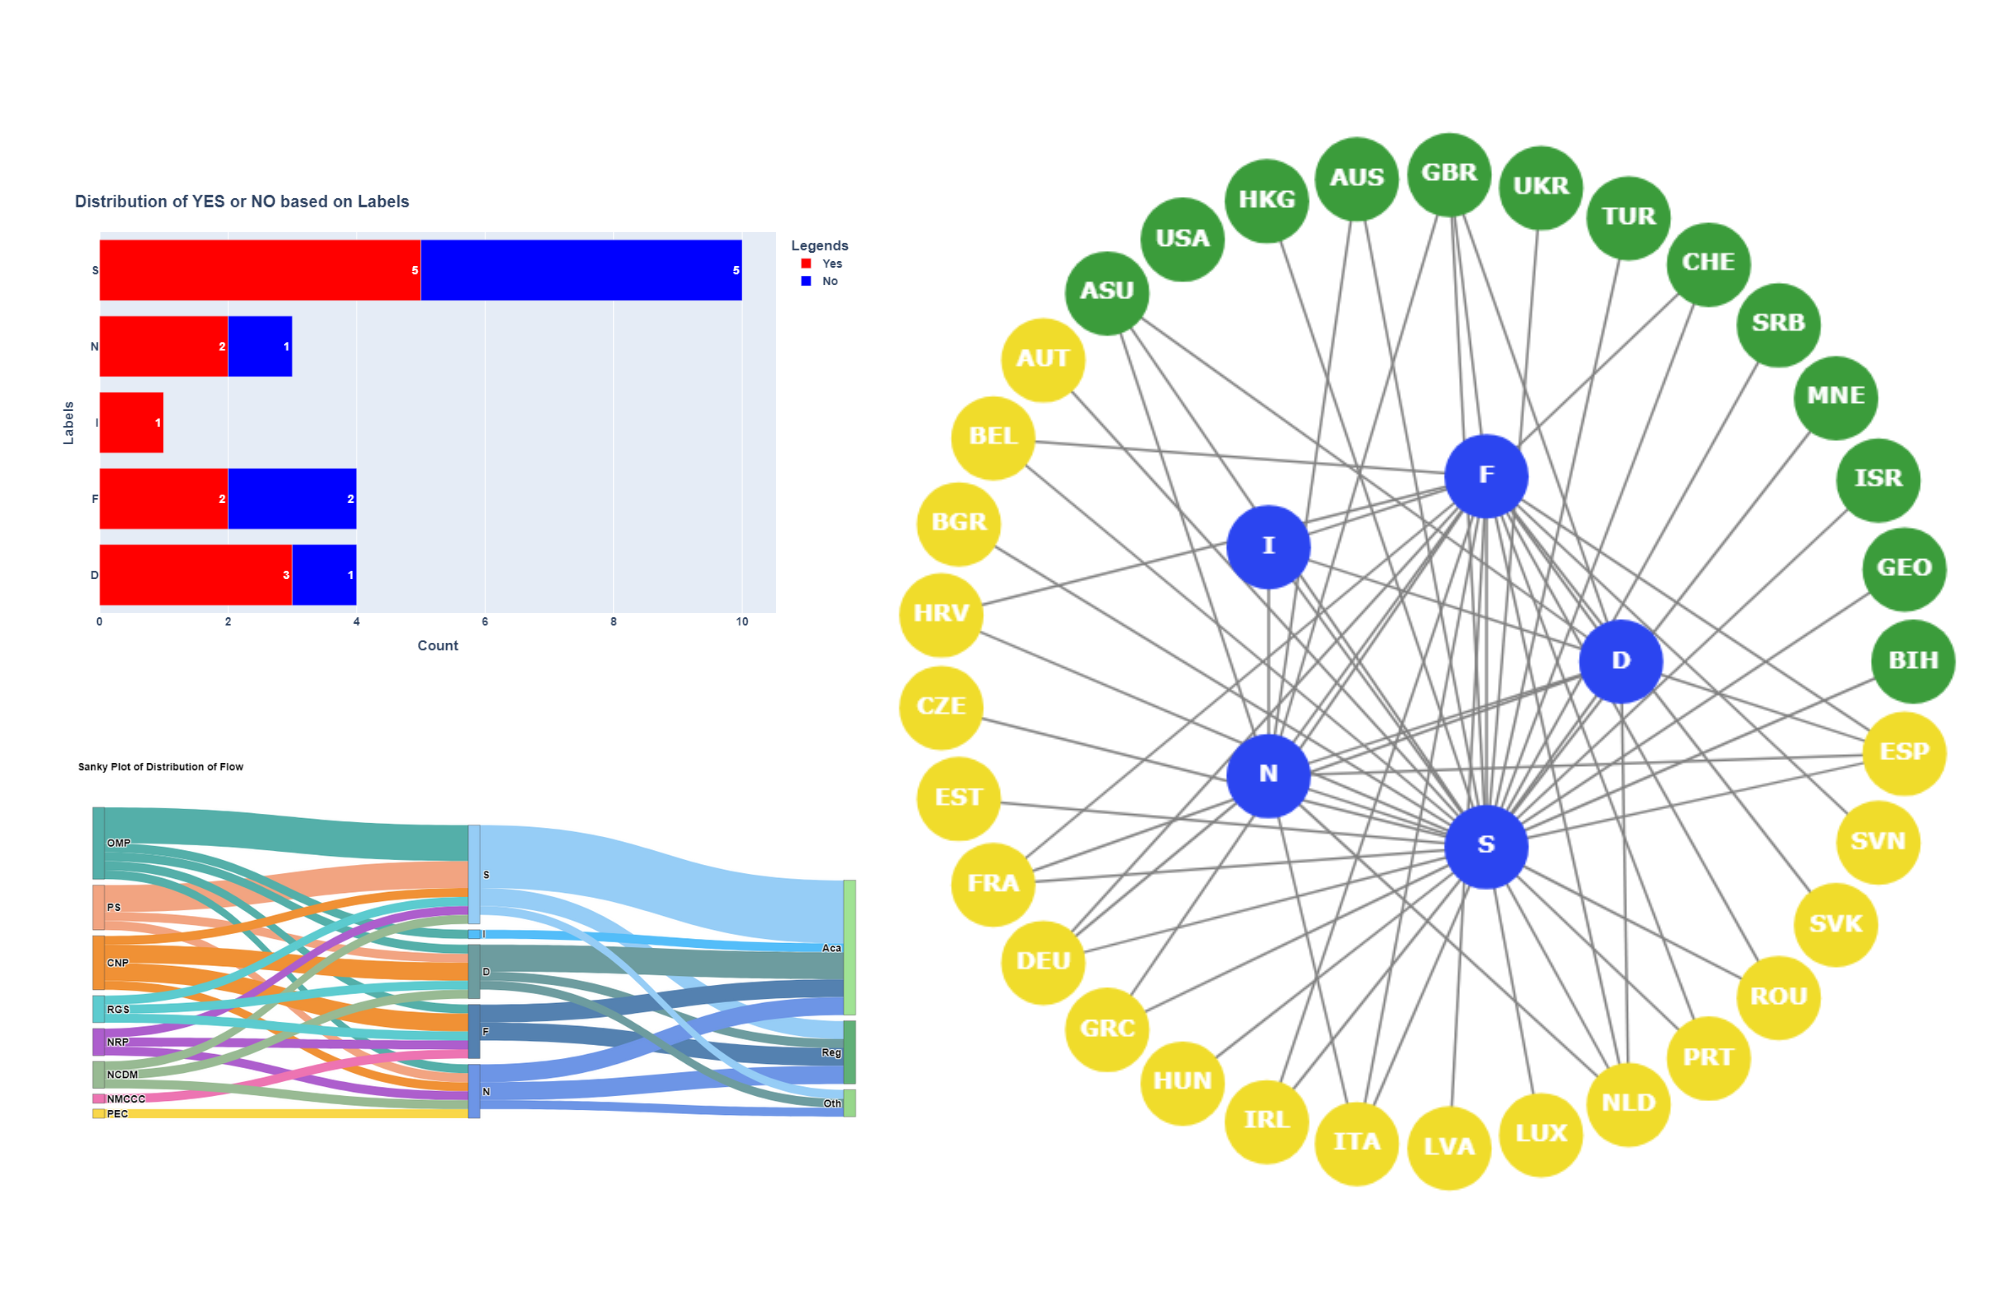

In [11]:
from IPython.display import Image
Image("images/collated_graphs.png")